In [1]:
import subprocess
import os
import multiprocessing
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.insert(1, '../src')
from uniswapv3data.bigquery_downloader import BigQueryUniswapV3Downloader

%matplotlib inline

INTERVAL_SIZE = 1.0001

DATE_BEGIN                 = pd.to_datetime('2022-01-01 00:00AM',utc=True)
DATE_END                   = pd.to_datetime('2023-01-01 00:00AM',utc=True)

BIGQUERY_CREDENTIALS_PATH = 'data/bigquery_auth.json'

POOLS = [
    {
        'address':  '0x3416cF6C708Da44DB2624D63ea0AAef7113527C6',
        'token0_decimals': 6,
        'token1_decimals': 6,
        'fee_tier': 0.0001,
        'tick_spacing': 1,
        'pool_name': 'usdc_usdt',
        'controller_exponent': 10
    },
    {
        'address':  '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
        'token0_decimals': 6,
        'token1_decimals': 18,
        'fee_tier': 0.003,
        'tick_spacing': 60,
        'pool_name': 'usdc_eth',
        'controller_exponent': 4
    }
]

In [2]:
pool = POOLS[0]

file_path = f"./data/{pool['pool_name']}_{int(DATE_BEGIN.timestamp())}_{int(DATE_END.timestamp())}.csv.gz"
if os.path.exists(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=['block_timestamp'])
else:
    downloader = BigQueryUniswapV3Downloader(BIGQUERY_CREDENTIALS_PATH)
    data = downloader.download_pool_data(pool['address'], DATE_BEGIN, DATE_END)
    data.to_csv(file_path)
    
data = data.drop(columns=['data'])


data['volume_in_token_0'] = data[["amount0","amount1","price"]].apply(lambda x: -x[0] if x[0] < 0 else -x[1]/x[2], axis=1)
data['relative_volume_in_token_0'] = data[["volume_in_token_0","price","liquidity"]].apply(lambda x: x[0] * np.sqrt(x[1]) / (2*x[2]) if x[2] > 0 else 0, axis=1)
data

,block_number,transaction_index,log_index,block_timestamp,amount0,amount1,price,liquidity,tick,volume_in_token_0,relative_volume_in_token_0
0,13916167,55,115,2022-01-01 00:00:09+00:00,1.335916e+10,-1.335778e+10,0.999997,4.303942e+17,1.157921e+77,1.335782e+10,1.551810e-08
1,13916174,87,48,2022-01-01 00:01:23+00:00,5.000000e+10,-4.999482e+10,0.999996,4.303942e+17,1.157921e+77,4.999501e+10,5.808037e-08
2,13916185,240,348,2022-01-01 00:03:25+00:00,-1.000000e+09,1.000096e+09,0.999996,4.303942e+17,1.157921e+77,1.000000e+09,1.161723e-09
3,13916203,87,174,2022-01-01 00:06:44+00:00,8.698968e+09,-8.698066e+09,0.999996,4.303942e+17,1.157921e+77,8.698098e+09,1.010478e-08
4,13916223,5,26,2022-01-01 00:10:01+00:00,3.695344e+09,-3.694961e+09,0.999996,4.303942e+17,1.157921e+77,3.694975e+09,4.292539e-09
...,...,...,...,...,...,...,...,...,...,...,...
308669,16308132,1,27,2022-12-31 23:48:35+00:00,2.603485e+09,-2.604233e+09,1.000387,1.115700e+17,3.000000e+00,2.603225e+09,1.166859e-08
308670,16308134,7,23,2022-12-31 23:48:59+00:00,-1.999026e+09,2.000000e+09,1.000387,1.115700e+17,3.000000e+00,1.999026e+09,8.960353e-09
308671,16308165,83,295,2022-12-31 23:55:11+00:00,-1.999026e+10,2.000000e+10,1.000388,1.115700e+17,3.000000e+00,1.999026e+10,8.960353e-08
308672,16308170,31,66,2022-12-31 23:56:11+00:00,-1.049488e+08,1.050000e+08,1.000388,1.115700e+17,3.000000e+00,1.049488e+08,4.704185e-10


In [3]:
def simulate_static_controller(controller):
    proc = subprocess.run(['../src/uniswapv3simulator/uniswapv3simulator', file_path, str(pool['fee_tier']), str(pool['tick_spacing']), str(controller)], check=True, capture_output=True)
    return list(map(np.float64, proc.stdout.decode().split()))

controllers = pool['controller_exponent']**np.arange(int(np.log(9*np.log(10) / (pool['tick_spacing']*np.log(INTERVAL_SIZE))) / np.log(pool['controller_exponent']))+2)

with multiprocessing.Pool(min(10,len(controllers))) as p:
    rewards = pd.DataFrame(p.map(simulate_static_controller, controllers)).T.rename(columns={i:f'value_in_0_for_controller_{controller}' for i,controller in enumerate(controllers)})
    
for controller in controllers:
    rewards[f'log_reward_for_controller_{controller}'] = np.log(rewards[f'value_in_0_for_controller_{controller}'] / rewards.set_index(rewards.index+1)[f'value_in_0_for_controller_{controller}'])
    
data = pd.concat([data,rewards], axis=1).dropna().set_index('block_timestamp')
del rewards
data

,block_number,transaction_index,log_index,amount0,amount1,price,liquidity,tick,volume_in_token_0,relative_volume_in_token_0,...,value_in_0_for_controller_10000,value_in_0_for_controller_100000,value_in_0_for_controller_1000000,log_reward_for_controller_1,log_reward_for_controller_10,log_reward_for_controller_100,log_reward_for_controller_1000,log_reward_for_controller_10000,log_reward_for_controller_100000,log_reward_for_controller_1000000
block_timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:01:23+00:00,13916174,87,48,5.000000e+10,-4.999482e+10,0.999996,4.303942e+17,1.157921e+77,4.999501e+10,5.808037e-08,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-01-01 00:03:25+00:00,13916185,240,348,-1.000000e+09,1.000096e+09,0.999996,4.303942e+17,1.157921e+77,1.000000e+09,1.161723e-09,...,1.000000,1.000000,1.000000,1.161607e-07,1.161607e-07,1.161607e-07,1.161607e-07,1.161607e-07,1.161607e-07,1.161607e-07
2022-01-01 00:06:44+00:00,13916203,87,174,8.698968e+09,-8.698066e+09,0.999996,4.303942e+17,1.157921e+77,8.698098e+09,1.010478e-08,...,1.000000,1.000000,1.000000,-2.323447e-09,-2.323447e-09,-2.323447e-09,-2.323447e-09,-2.323447e-09,-2.323447e-09,-2.323447e-09
2022-01-01 00:10:01+00:00,13916223,5,26,3.695344e+09,-3.694961e+09,0.999996,4.303942e+17,1.157921e+77,3.694975e+09,4.292539e-09,...,1.000000,1.000000,1.000000,2.020957e-08,2.020957e-08,2.020957e-08,2.020957e-08,2.020957e-08,2.020957e-08,2.020957e-08
2022-01-01 00:12:04+00:00,13916232,122,130,1.291685e+10,-1.291551e+10,0.999996,4.303942e+17,1.157921e+77,1.291556e+10,1.500431e-08,...,1.000000,1.000000,1.000000,8.585078e-09,8.585078e-09,8.585078e-09,8.585078e-09,8.585078e-09,8.585078e-09,8.585078e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:48:35+00:00,16308132,1,27,2.603485e+09,-2.604233e+09,1.000387,1.115700e+17,3.000000e+00,2.603225e+09,1.166859e-08,...,1.158025,1.193215,1.191853,-3.543077e-09,-2.454670e-08,-2.664706e-08,-2.685710e-08,-2.687806e-08,-2.687985e-08,-2.687986e-08
2022-12-31 23:48:59+00:00,16308134,7,23,-1.999026e+09,2.000000e+09,1.000387,1.115700e+17,3.000000e+00,1.999026e+09,8.960353e-09,...,1.158025,1.193215,1.191853,4.125838e-08,2.512968e-08,2.351680e-08,2.335552e-08,2.333943e-08,2.333805e-08,2.333804e-08
2022-12-31 23:55:11+00:00,16308165,83,295,-1.999026e+10,2.000000e+10,1.000388,1.115700e+17,3.000000e+00,1.999026e+10,8.960353e-08,...,1.158025,1.193215,1.191853,1.612919e-07,4.641398e-12,-1.612411e-08,-1.773696e-08,-1.789791e-08,-1.791166e-08,-1.791172e-08


In [4]:
steps = []
current_date = DATE_BEGIN

while current_date < DATE_END:
    swaps = data[current_date:current_date + pd.DateOffset(hours=1)]
    step = {
        'date': current_date,
        'relative_volume_in_token_0': swaps['relative_volume_in_token_0'].sum(),
        'last_price': swaps.iloc[-1]['price'] if len(swaps) else steps[-1]['last_price']
    }
    
    step['log_price_change'] = np.log(step['last_price'] / steps[-1]['last_price']) / (pool['tick_spacing'] * np.log(INTERVAL_SIZE)) if len(steps) else 0
    
    for controller in controllers:
        step[f'log_reward_for_controller_{controller}'] = swaps[f'log_reward_for_controller_{controller}'].sum()
      
    steps.append(step)
    current_date += pd.DateOffset(hours=1)

steps = pd.DataFrame(steps[1:]).set_index('date')
steps

,relative_volume_in_token_0,last_price,log_price_change,log_reward_for_controller_1,log_reward_for_controller_10,log_reward_for_controller_100,log_reward_for_controller_1000,log_reward_for_controller_10000,log_reward_for_controller_100000,log_reward_for_controller_1000000
date,,,,,,,,,,
2022-01-01 01:00:00+00:00,1.882890e-06,0.999994,0.016332,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06
2022-01-01 02:00:00+00:00,1.481871e-06,0.999996,0.013215,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07
2022-01-01 03:00:00+00:00,6.419099e-07,0.999996,0.005117,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07
2022-01-01 04:00:00+00:00,2.264355e-06,0.999999,0.034232,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06
2022-01-01 05:00:00+00:00,2.290786e-06,0.999997,-0.026814,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,9.177448e-07,1.000355,0.013923,1.113871e-06,-5.381069e-07,-7.033048e-07,-7.198243e-07,-7.214728e-07,-7.216137e-07,-7.216143e-07
2022-12-31 20:00:00+00:00,9.972644e-07,1.000357,0.022286,8.806707e-07,-9.144443e-07,-1.093956e-06,-1.111907e-06,-1.113698e-06,-1.113851e-06,-1.113852e-06
2022-12-31 21:00:00+00:00,1.462231e-06,1.000362,0.050388,3.929640e-07,-2.239104e-06,-2.502311e-06,-2.528632e-06,-2.531258e-06,-2.531483e-06,-2.531484e-06


In [5]:
print('log_d(2)', np.log(2)/(pool['tick_spacing']*np.log(INTERVAL_SIZE)))
print('max |p_t|',np.abs(steps['log_price_change']).max())
print('d',INTERVAL_SIZE**pool['tick_spacing'])
print('d ^ (max |p_t|)',INTERVAL_SIZE**(pool['tick_spacing']*np.abs(steps['log_price_change']).max()))
print('P',np.abs(steps['log_price_change']).mean())
print('P ln d / gamma',np.abs(steps['log_price_change']).mean() * pool['tick_spacing']*np.log(INTERVAL_SIZE) / pool['fee_tier'])
print('10 P^2 ln^2 d / gamma',10 * (np.abs(steps['log_price_change']).mean() * pool['tick_spacing']*np.log(INTERVAL_SIZE))**2 / pool['fee_tier'])
print('max u_t',steps['relative_volume_in_token_0'].max())
print('median u',np.median(steps['relative_volume_in_token_0']))
print('mean u',steps['relative_volume_in_token_0'].mean())
print('2/gamma',2/pool['fee_tier'])

log_d(2) 6931.818373414559
max |p_t| 98.31209441600643
d 1.0001
d ^ (max |p_t|) 1.0098791981562107
P 0.23995793110235733
P ln d / gamma 0.23994593400557557
10 P^2 ln^2 d / gamma 5.7574051245808034e-05
max u_t 2205.056434210137
median u 3.5722613492997518e-06
mean u 0.3482023557900692
2/gamma 20000.0


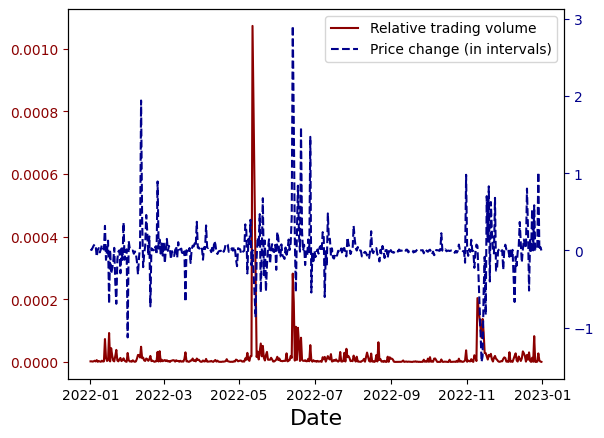

In [6]:
sprarse_steps = steps.iloc[::20]

price_variances = np.abs(sprarse_steps["log_price_change"] - sprarse_steps["log_price_change"].mean())
volume_variances = np.abs(sprarse_steps["relative_volume_in_token_0"] - sprarse_steps["relative_volume_in_token_0"].mean())
sprarse_steps = sprarse_steps[np.logical_and(price_variances < price_variances.quantile(0.99),volume_variances < volume_variances.quantile(0.99))]

fig,ax = plt.subplots()

color1 = 'darkred'
volume_line = ax.plot(sprarse_steps.index, sprarse_steps['relative_volume_in_token_0'], '', color=color1, label='Relative trading volume')[0]
ax.set_xlabel('Date', fontsize=16)
ax.tick_params(axis='y', colors=color1)
ax.legend()

color2  = 'darkblue'
ax2 = ax.twinx()
price_line = ax2.plot(sprarse_steps.index, sprarse_steps['log_price_change'], '--',color=color2, label='Price change (in intervals)')[0]
ax2.tick_params(axis='y', colors=color2)

ax.legend([volume_line, price_line], [volume_line.get_label(), price_line.get_label()], loc=1)

fig.savefig(f"./data/{pool['pool_name']}_{int(DATE_BEGIN.timestamp())}_{int(DATE_END.timestamp())}_volumes_prices.png", dpi=300, bbox_inches='tight')

In [7]:
learning_rate = 1000

rewards = []
mwa_probs = np.array([1/len(controllers) for _ in controllers])
for date,step in tqdm(steps.iterrows(), total=len(steps)):
    current_rewards = step[[f'log_reward_for_controller_{controller}' for controller in controllers]]
    
    ewa_reward = np.log(np.average(np.exp(current_rewards).to_numpy(), weights=mwa_probs))
    rewards.append(pd.concat([current_rewards, pd.Series({'ewa': ewa_reward})]))

    mwa_probs *= np.exp(learning_rate * current_rewards.to_numpy())
    mwa_probs /= mwa_probs.sum()

rewards = pd.DataFrame(rewards)
rewards['date'] = steps.index
rewards = rewards.set_index('date')

rewards.sum()

  0%|          | 0/8759 [00:00<?, ?it/s]

log_reward_for_controller_1          0.103630
log_reward_for_controller_10         0.009048
log_reward_for_controller_100        0.021380
log_reward_for_controller_1000       0.563162
log_reward_for_controller_10000      0.146740
log_reward_for_controller_100000     0.176675
log_reward_for_controller_1000000    0.175533
ewa                                  0.514702
dtype: float64

In [8]:
rewards

,log_reward_for_controller_1,log_reward_for_controller_10,log_reward_for_controller_100,log_reward_for_controller_1000,log_reward_for_controller_10000,log_reward_for_controller_100000,log_reward_for_controller_1000000,ewa
date,,,,,,,,
2022-01-01 01:00:00+00:00,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06,-1.236482e-06
2022-01-01 02:00:00+00:00,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07,-3.268450e-07
2022-01-01 03:00:00+00:00,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07,-3.696620e-07
2022-01-01 04:00:00+00:00,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06,-1.604473e-06
2022-01-01 05:00:00+00:00,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06,1.419479e-06
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00+00:00,1.113871e-06,-5.381069e-07,-7.033048e-07,-7.198243e-07,-7.214728e-07,-7.216137e-07,-7.216143e-07,-7.198243e-07
2022-12-31 20:00:00+00:00,8.806707e-07,-9.144443e-07,-1.093956e-06,-1.111907e-06,-1.113698e-06,-1.113851e-06,-1.113852e-06,-1.111907e-06
2022-12-31 21:00:00+00:00,3.929640e-07,-2.239104e-06,-2.502311e-06,-2.528632e-06,-2.531258e-06,-2.531483e-06,-2.531484e-06,-2.528632e-06


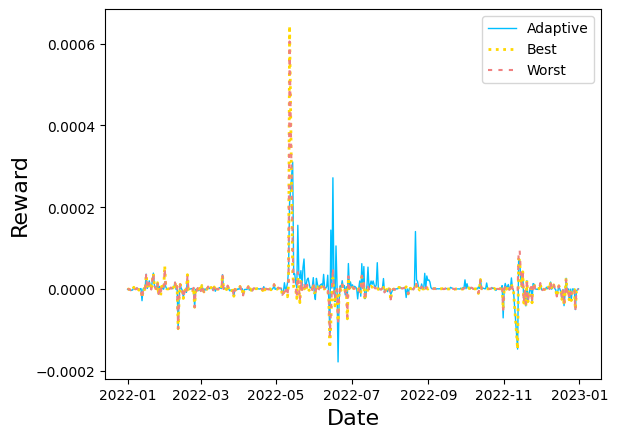

In [9]:
sprarse_rewards = rewards.iloc[::20]

reward_variances = np.abs(sprarse_rewards["ewa"] - sprarse_rewards["ewa"].mean())
sprarse_rewards = sprarse_rewards[reward_variances < reward_variances.quantile(0.99)]

fig,ax = plt.subplots()

ax.plot(sprarse_rewards.index, sprarse_rewards['ewa'], '',label='Adaptive', color='deepskyblue', linewidth=1)
ax.plot(sprarse_rewards.index, sprarse_rewards[rewards.sum().drop('ewa').idxmax()], ':',label='Best', color='gold', linewidth=2)
ax.plot(sprarse_rewards.index, sprarse_rewards[rewards.sum().drop('ewa').idxmin()], '--',dashes=(2, 3),label='Worst', color='lightcoral',linewidth=1.5)

ax.legend()
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Reward', fontsize=16)

fig.savefig(f"./data/{pool['pool_name']}_{int(DATE_BEGIN.timestamp())}_{int(DATE_END.timestamp())}_rewards.png", dpi=300, bbox_inches='tight')